<a href="https://colab.research.google.com/github/PaulaLuana/biofacil/blob/master/projeto2_sequence_to_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Beyond text classification: Sequence-to-sequence learning

### A machine translation example

In [ ]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2022-01-27 19:07:31--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 142.251.5.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.52M  --.-KB/s    in 0.02s   

2022-01-27 19:07:31 (104 MB/s) - ‘spa-eng.zip’ saved [2638744/2638744]



In [ ]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

In [ ]:
import random
print(random.choice(text_pairs))

('I thought Tom was your surgeon.', '[start] Pensé que Tom era tu cirujano. [end]')


In [ ]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Vectorizing the English and Spanish text pairs**

O código a seguir implmenta uma camada pre-processam os textos (source e target) e vetoriza no formato de one-hot vector (gerando o índice do vetor em que a palavra tem valor 1). 
*   A variável **vocab_size** define a quantidade de palavras do vocabulário que impactará diretamente no tamanho dos vetores 

In [ ]:
import tensorflow as tf
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

### 1 ) Crie um modelo sequencial que recebe como entrada os dados de treino e retorna o dataset vetorizado. Para isso, tal modelo tem duas camadas a primeira é um Input e a segunda é o TextVectorization definido na célula anterior. Para fazer a transformação, utilize o método predict do modelo.

### 2) Altere a definição das camadas de TextVectorization definidas anteriormente para utilizar um vocabulário de tamanho 5000. Essa camadas serão utilizadas posteriormente no seu tradutor.

**Preparing datasets for the translation task**

In [ ]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:])

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### Sequence-to-sequence learning with RNNs

**GRU-based encoder**

**GRU-based decoder and the end-to-end model**

### GRU

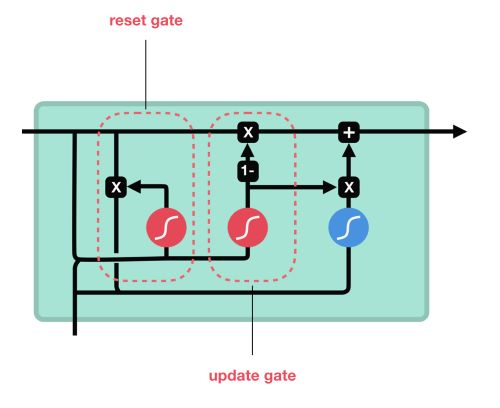

### RNN Bidirecional

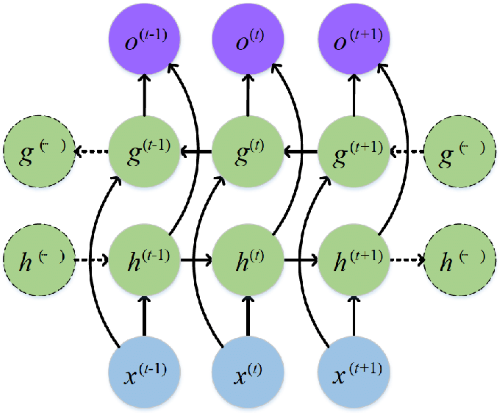

### 3) O código a seguir implementa o componente de codificação (Encondeer). Altere a dimensão dos vetores resultantes da camada de *embedding* para 128 e a dimensão dos vetores resultantes da camada recorrente do Encoder para 512. Troque a rede recorrente bidirecional para utilizaar uma arquitetura LSTM. 

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 128
latent_dim = 512

source = keras.Input(shape=(None,), dtype="int64", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoder_outputs, state_h, state_c = layers.LSTM(latent_dim, return_state=True)(x)
encoder_states = [state_h, state_c]

### 4) O código a seguir implementa a caamada Decoder e o modelo final, conectando o Encoder ao Decoder. A célula seguinte deve receber como parâmetro a lista de entradas do modelo e a saída esperada para a entrada. Complete o código que define o modelo com os parâmetros corretos.

In [ ]:
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _  = decoder_gru(x, initial_state=encoder_states)
decoder_outputs = layers.Dropout(0.5)(decoder_outputs)

target_next_step = layers.Dense(vocab_size, activation="softmax")(decoder_outputs)

In [ ]:
seq2seq_rnn = keras.Model([source, past_target], target_next_step)

### 4) Utilize a função plot_model do pacote utils para imprimir o diagrama da arquitetura do seu modelo.

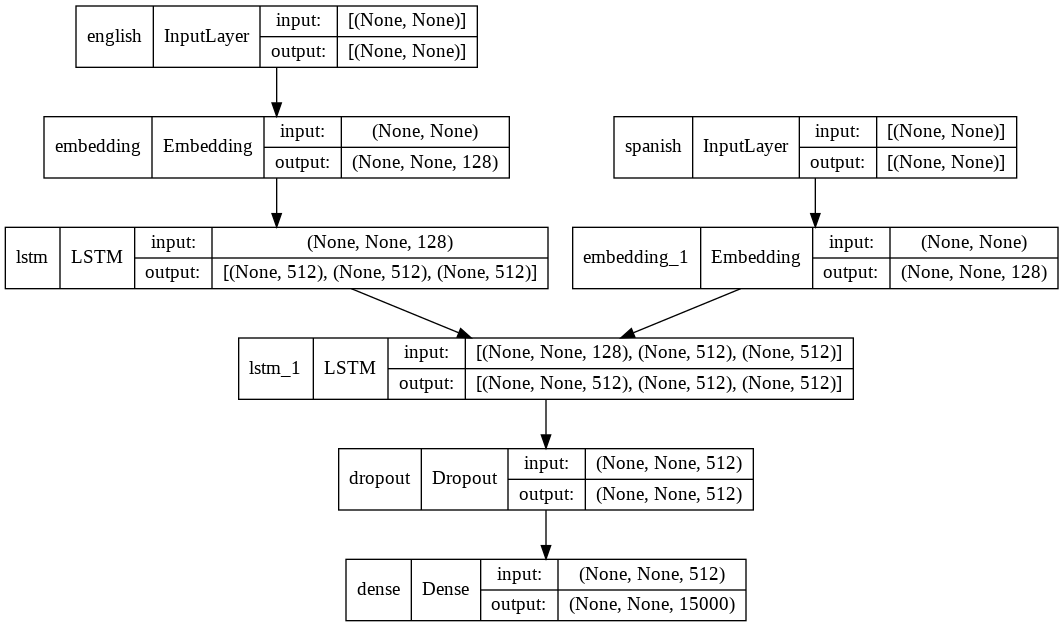

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(seq2seq_rnn, to_file=dot_img_file, show_shapes=True)

### 5) Utilize a função summary para visualizar a quantidade de parâmetros treináveis do seu modelo. Quantos parâmetros treináveis e não treináveis tem o seu modelo? Como esse número se compara ao exemplo dado na aula e porquê?

In [ ]:
seq2seq_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 spanish (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    1920000     ['english[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    1920000     ['spanish[0][0]']                
                                                                                              

**Training our recurrent sequence-to-sequence model**

### 6) Utilize o código a seguir para treinar o modelo. Lembre-se de ativar a GPU do colab. (Em caso de demora, reduza o tamanho do dataset de treino)

In [ ]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 [==============================] - 82s 54ms/step - loss: 1.8539 - accuracy: 0.3307 - val_loss: 1.5835 - val_accuracy: 0.3992
Epoch 2/15
1302/1302 [==============================] - 71s 54ms/step - loss: 1.5549 - accuracy: 0.4255 - val_loss: 1.3856 - val_accuracy: 0.4659
Epoch 3/15
1302/1302 [==============================] - 70s 54ms/step - loss: 1.4115 - accuracy: 0.4751 - val_loss: 1.2751 - val_accuracy: 0.5062
Epoch 4/15
1302/1302 [==============================] - 70s 53ms/step - loss: 1.3152 - accuracy: 0.5094 - val_loss: 1.1982 - val_accuracy: 0.5380
Epoch 5/15
1302/1302 [==============================] - 69s 53ms/step - loss: 1.2464 - accuracy: 0.5369 - val_loss: 1.1495 - val_accuracy: 0.5622
Epoch 6/15
1302/1302 [==============================] - 70s 54ms/step - loss: 1.1992 - accuracy: 0.5590 - val_loss: 1.1194 - val_accuracy: 0.5774
Epoch 7/15
1302/1302 [==============================] - 69s 53ms/step - loss: 1.1674 - accuracy: 0.5781 - val_loss: 1.0989 -

### 7) O código a seguir implementa a inferência da tradução a partir de um modelo treinado. Sortei 10 textos do dataset de teste em inglês **test_eng_texts** e imprima as traduções.

**Translating new sentences with our RNN encoder and decoder**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]


In [ ]:
texts_english = []
for i in range(10):
  texts_english.append((random.choice(test_eng_texts)))
texts_english

['I like being alone.',
 'Tom died Monday.',
 'He is no stranger to me.',
 'Tom wants to get rich quick.',
 "I'd like to help.",
 'Tom has straight hair.',
 'She was injured in the traffic accident.',
 'Nothing is forever.',
 "Tom was afraid he'd lost his key.",
 "I'd like to read it."]

In [ ]:
for i in texts_english:
  print(decode_sequence(i))

[start] me gusta estar solo [end]
[start] tom murió el lunes [end]
[start] Él no me está [UNK] [end]
[start] tom quiere ser [UNK] el poco [end]
[start] me gustaría ayudar [end]
[start] tom tiene el pelo [UNK] [end]
[start] ella se [UNK] en el accidente de accidente [end]
[start] nada no está bien [end]
[start] tom le tenía miedo de que se [UNK] la llave [end]
[start] me gustaría leer [end]


[good morning] [start] -> bom 
[good morning] [start bom ] -> dia 
[good morning] [start bom dia] -> end


## Summary